In [34]:
from cheat.game import CheatGame
from cheat.bots import RandomBot
import numpy as np
import asyncio
import logging
import tqdm
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

In [39]:
# Fill up with bots
def setup_game(num_players):
    game_players=[]
    for i in range(num_players):
        game_players.append(RandomBot(
            id=i,
            name=f'bot_{i}',
            avatar='🌼',
            p_call=np.random.rand(),
            p_lie=np.random.rand(),
            verbosity=0
        ))

    # Set up a new game. Each game maintains its own message queue
    game = CheatGame(
        players=game_players,
        experimental_mode=False,
        game_mode='single',
        message_queue = asyncio.Queue(), # Set up a new queue
        out_dir=None
    )
    game.logger.setLevel(logging.CRITICAL)
    game.player_logger.setLevel(logging.CRITICAL)
    return game

In [ ]:
winner_properties = []

In [41]:
# Play 1000 rounds
for _ in tqdm.trange(1000):
    game = setup_game(num_players=6)
    await game.play_round(sleep_pause=0)
    winner_properties.append((game.players[game.winner].p_call, game.players[game.winner].p_lie))

 80%|████████  | 802/1000 [1:16:21<18:51,  5.71s/it]  


CancelledError: 

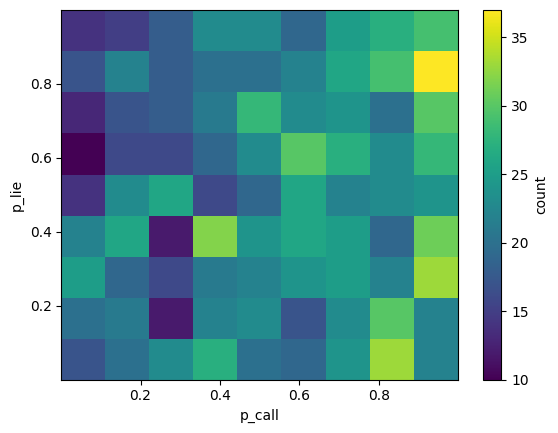

In [46]:
data = np.array(winner_properties)
x, y = data[:,0], data[:,1]
# Define bin edges
xbins = np.linspace(x.min(), x.max(), 10)   # 50 bins
ybins = np.linspace(y.min(), y.max(), 10)

# 2D counts
counts, _, _, _ = binned_statistic_2d(
    x, y, None, statistic='count', bins=[xbins, ybins]
)

plt.imshow(
    counts.T,
    origin='lower',
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    aspect='auto'
)
plt.colorbar(label='count')
plt.xlabel('p_call')
plt.ylabel('p_lie')
plt.show()